In [6]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [58]:
input_files = ['../../resources/matrices/e40r5000.mtx',
               '../../resources/matrices/Serena/Serena.mtx',
               '../../resources/matrices/Flan_1565/Flan_1565.mtx',
               '../../resources/matrices/nlpkkt200/nlpkkt200.mtx',
               ]

uns_input_files = ['../../resources/matrices/e40r5000.mtx',
                   '../../resources/matrices/Serena/Serena.uns.mtx',
                   '../../resources/matrices/Flan_1565/Flan_1565.uns.mtx',
                   '../../resources/matrices/nlpkkt200/nlpkkt200.uns.mtx',
                   ]

h5_comp_files = ['../../resources/matrices/e40r5000.comp.csr.h5',
                 '../../resources/matrices/Serena/Serena.comp.csr.h5',
                 '../../resources/matrices/Flan_1565/Flan_1565.comp.csr.h5',
                 '../../resources/matrices/nlpkkt200/nlpkkt200.comp.csr.h5',
                 ]

h5_input_files = [file.replace('.mtx', '.csr.h5') for file in input_files]


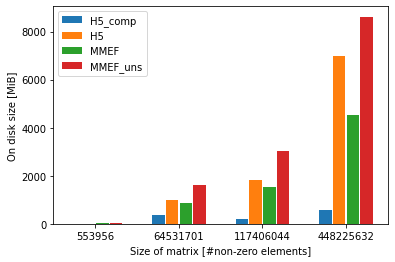

In [89]:
import os
from pathlib import Path


def gen_sizes(paths):
    return np.array([Path(file).stat().st_size for file in paths]) / (1024 * 1024)


sizes = np.array([553956, 64531701, 117406044, 448225632])
x_axis = np.arange(4)

col_width = 0.15

half_col = col_width / 2
padding = 0.015

offset = half_col + padding

first_col_off = (half_col + padding/2)
second_col_off = first_col_off + padding + 2*half_col

h5_comp_sizes = gen_sizes(h5_comp_files)
h5_sizes = gen_sizes(h5_input_files)
mmef_sizes = gen_sizes(input_files)
mmef_uns_sizes = gen_sizes(uns_input_files)

plt.bar(x_axis - second_col_off, h5_comp_sizes, col_width, label='H5_comp')
plt.bar(x_axis - first_col_off, h5_sizes, col_width, label='H5')
plt.bar(x_axis + first_col_off, mmef_sizes, col_width, label='MMEF')
plt.bar(x_axis + second_col_off, mmef_uns_sizes, col_width, label='MMEF_uns')

plt.ylabel("On disk size [MiB]")

plt.xticks(x_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")

plt.legend()

plt.savefig('storage_sizes.png')
plt.show()


[2007086.95652174 4933239.12544912 4696241.76       6423503.23163129] 4515017.76840054
[2840800.         6620673.13019391 6931108.3298896  7880197.46835443] 6068194.732109485
[4.58554589e+07 1.69578963e+08 8.12628881e+07 1.43326062e+08] 110005843.06783956
[14290115.16529172 22136386.57040031 35580635.92545545 36292211.5047968 ] 27074837.29148607
1.3440024033967786 24.36443192709948 18.12826514708737 4.063028777736437
4.461761444177328 5.9966181043574105


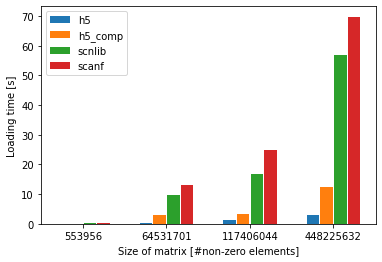

In [102]:
scanf = np.array([0.276,
                  13.081,
                  25.000,
                  69.779])

scnlib = np.array([0.195,
                   9.747,
                   16.939,
                   56.880])

h5 = np.array([0.012080481,
               0.380540722,
               1.444768292,
               3.127314214])

h5_comp = np.array([0.038764978,
                    2.915186758,
                    3.299717415,
                    12.350463458])


scanf_throughput = sizes / scanf
scnlib_throughput = sizes / scnlib
h5_throughput = sizes / h5
h5_comp_throughput = sizes / h5_comp

scanf_avg_thr = np.average(scanf_throughput)
scnlib_avg_thr = np.average(scnlib_throughput)
h5_avg_thr = np.average(h5_throughput)
h5_comp_avg_thr = np.average(h5_comp_throughput)

print(scanf_throughput, scanf_avg_thr)
print(scnlib_throughput, scnlib_avg_thr)
print(h5_throughput, h5_avg_thr)
print(h5_comp_throughput, h5_comp_avg_thr)

print(scnlib_avg_thr / scanf_avg_thr, h5_avg_thr /
      scanf_avg_thr, h5_avg_thr / scnlib_avg_thr, h5_avg_thr / h5_comp_avg_thr)

print(h5_comp_avg_thr / scnlib_avg_thr, h5_comp_avg_thr / scanf_avg_thr)

X_axis = np.arange(4)

plt.bar(X_axis - second_col_off, h5, col_width, label='h5')
plt.bar(X_axis - first_col_off, h5_comp, col_width, label='h5_comp')
plt.bar(X_axis + first_col_off, scnlib, col_width, label='scnlib')
plt.bar(X_axis + second_col_off, scanf, col_width, label='scanf')
plt.xticks(X_axis, sizes)
plt.xlabel("Size of matrix [#non-zero elements]")
plt.ylabel("Loading time [s]")
plt.title("")
plt.legend()
plt.savefig('matrix_loading.png')
plt.show()


In [93]:
print(h5_sizes)
print(h5_comp_sizes)

display(h5_sizes / h5_comp_sizes)
display(mmef_sizes / h5_comp_sizes)

[   8.58882141  995.29504395 1803.41677094 6963.28601837]
[  3.42625904 368.2189455  198.03269863 577.53638172]


array([ 2.50676359,  2.70299792,  9.10666159, 12.05687856])

array([4.89085959, 2.30146336, 7.7861422 , 7.81995158])